In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
moc_df = pd.read_csv('.\data\merit_order_curve.csv', sep='\t')
moc_df.head() 

,Load (GW),Marginal Cost ($/MWh)
0,0.000000,0.239521
1,0.711111,0.239521
2,0.622222,3.832335
3,0.622222,7.185629
4,0.711111,10.299401


<AxesSubplot: xlabel='Load (GW)', ylabel='Marginal Cost ($/MWh)'>

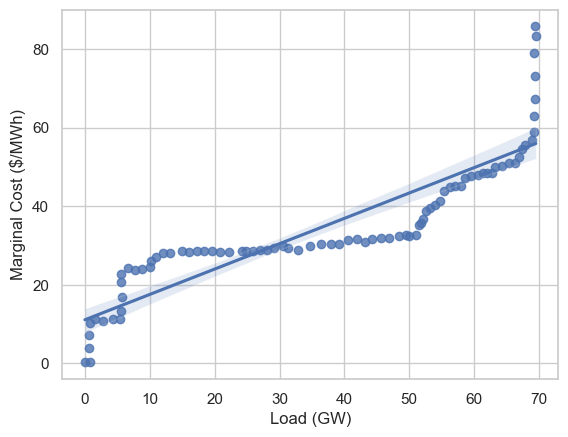

In [3]:
sns.set_theme(style="whitegrid")
sns.regplot(x="Load (GW)", y="Marginal Cost ($/MWh)", data=moc_df)

In [4]:
# X = moc_df['Load (GW)'].values.reshape(-1,1)
# y = moc_df['Marginal Cost ($/MWh)'].values
# from sklearn.linear_model import *
# from lineartree import LinearTreeRegressor, LinearTreeClassifier
# model = LinearTreeRegressor(base_estimator=LinearRegression())
# model.fit(X, y)

# plt.plot(X, y, ".", label='TRUE')
# plt.plot(X, model.predict(X), label='PRED')
# plt.legend()

In [5]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
# segmented linear regression parameters
np.random.seed(0)
n_seg = 3
xs = moc_df['Load (GW)'].values[18:-10]
ys = moc_df['Marginal Cost ($/MWh)'].values[18:-10]
dys = np.gradient(ys, xs)
print(dys)


[ 8.98203597e-01  4.67065871e-01  1.06151333e-01 -3.92964079e-02
 -3.20786986e-02  9.26718007e-02  0.00000000e+00 -9.26718007e-02
 -1.02651840e-01  5.15714983e-02  3.26619489e-02 -1.77635684e-15
  1.90004609e-01  1.90004609e-01  1.90004603e-01  3.88892543e-01
 -2.39520959e-01 -4.99001998e-01  9.76993390e-02  4.04191617e-01
  1.61676649e-01  0.00000000e+00 -3.14371257e-01  8.98203592e-02
 -1.10591318e+00 -1.02651840e+00  2.52311314e-01  2.58233535e-01
  2.50911217e-01  2.72668947e-01  1.34730541e-01  4.63941675e+00
  3.34580833e+00  2.18135158e+00  3.23353294e+00  2.69461079e+00
  1.14520957e+00  1.46505307e+00  2.88708298e+00  3.22312904e+00
 -2.47005982e-01  7.29790426e-01  7.18274991e-01  7.74165955e-01
  3.96026132e-01  2.84431136e-01 -3.14371256e-01 -2.13162821e-14
  5.63578728e-01  8.83233534e-01  3.06205772e-01  1.68413175e+00
  3.36826345e+00  3.01306476e+00  2.15568866e+00]


[[0.12335914]] [25.94423036]
[[0.79765603]] [-0.46709622]
[[2.27730731]] [-82.24984576]
[[10.93333333, 27.292956993561617], [57.95555556, 45.76150227735441], [67.82, 53.63], [51.02222222, 33.943433956636]]
[[10.93333333, 27.292956993561617], [51.02222222, 33.943433956636], [57.95555556, 45.76150227735441], [67.82, 53.63]]


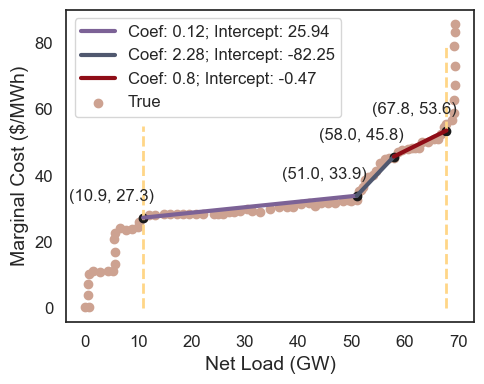

In [6]:
fig= plt.figure(figsize=(5,4))
sns.set_theme(style="white")

### Vertical lines to focus
# yyy = np.arange(0,80,2)
# xxx_1 = xs[0]*np.ones(40)
# xxx_2 = xs[-1]*np.ones(40)
plt.plot([xs[0],xs[0]],[0,55],color='#FFD687',linewidth= 2, linestyle = "--")
plt.plot([xs[-1],xs[-1]],[0,80],color='#FFD687',linewidth= 2, linestyle = "--")

rgr = DecisionTreeRegressor(max_leaf_nodes=n_seg)
rgr.fit(xs.reshape(-1, 1), dys.reshape(-1, 1))
dys_dt = rgr.predict(xs.reshape(-1, 1)).flatten()

ys_sl = np.ones(len(xs)) * np.nan
pair_set = []
data = []
alpha= []
beta= []
for y in np.unique(dys_dt):
    msk = dys_dt == y
    # print(msk)
    lin_reg = LinearRegression()
    lin_reg.fit(xs[msk].reshape(-1, 1), ys[msk].reshape(-1, 1))
    beta.append(round(lin_reg.coef_[0][0],2)) 
    alpha.append(round(lin_reg.intercept_[0],2))
    print(lin_reg.coef_, lin_reg.intercept_)
    ys_sl[msk] = lin_reg.predict(xs[msk].reshape(-1, 1)).flatten()
    # plt.plot([xs[msk][0], xs[msk][-1]],
    #          [ys_sl[msk][0], ys_sl[msk][-1]],
    #          color='#483100', zorder=5,linewidth = 3, label='Fit')
    pair_set.append([xs[msk][0],ys_sl[msk][0]])
    data.append(xs[msk][0])
    if xs[msk][-1] == xs[-1]:
        pair_set.append([round(xs[msk][-1],2),round(ys_sl[msk][-1],2)])
print(pair_set)
pair_set = sorted(pair_set, key=lambda x: x[0])
print(pair_set)
sorted_data = sorted(data)
original_order = sorted(range(len(data)), key=lambda x: data[x])
sorted_alpha = [alpha[i] for i in original_order]
sorted_beta = [beta[i] for i in original_order]

color_set=["#7C6296", "#50586F", "#8F0D17"]
for i in range(len(pair_set)-1):
    plt.plot([pair_set[i][0], pair_set[i+1][0]],
             [pair_set[i][1], pair_set[i+1][1]],
             color=color_set[i], zorder=5,linewidth = 3, label='Coef: '+str(sorted_beta[i])+'; Intercept: '+str(sorted_alpha[i]))
plt.scatter(moc_df['Load (GW)'].values, moc_df['Marginal Cost ($/MWh)'].values, label='True', c= '#CDA291')
plt.scatter( [t[0] for t in pair_set],  [t[1] for t in pair_set], c= 'k')
for i in range(len(pair_set)):
    plt.text(pair_set[i][0]-6, pair_set[i][1]+4, f'({round(pair_set[i][0],1)}, {round(pair_set[i][1],1)})', ha='center', va='bottom')
# plt.title('values')
# plt.scatter(xs, ys_sl, s=9, label='Fit', color='#FFD687', zorder=5)
plt.xlabel('Net Load (GW)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Marginal Cost ($/MWh)', fontsize=14)
plt.legend(fontsize=12)
fig.tight_layout()
plt.savefig(".\pics\merit_order_curve.pdf")